In [12]:
import pandas as pd
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import optuna
import time

from sklearn.base import clone
from sklearn.metrics import mean_squared_error

X_train = pd.read_csv('data/validation/X_train.csv')
y_train = pd.read_csv('data/validation/y_train.csv')['saleprice']

X_test = pd.read_csv('data/validation/X_val1.csv')
y_test = pd.read_csv('data/validation/y_val1.csv')['saleprice']

X_val2 = pd.read_csv('data/validation/X_val2.csv')
X_val3 = pd.read_csv('data/validation/X_val3.csv')
X_val4 = pd.read_csv('data/validation/X_val4.csv')

y_val2 = pd.read_csv('data/validation/y_val2.csv')
y_val3 = pd.read_csv('data/validation/y_val3.csv')
y_val4 = pd.read_csv('data/validation/y_val4.csv')


X_val = pd.concat([X_val2, X_val3, X_val4])
y_val =  pd.concat([y_val2, y_val3, y_val4])['saleprice']

In [13]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_val, enable_categorical=True)

In [14]:
dtrainval = xgb.DMatrix(
    pd.concat([X_train, X_val]),
    label=pd.concat([y_train, y_val]),
    enable_categorical=True,
)

In [16]:
def score_model(model: xgb.core.Booster, dmat: xgb.core.DMatrix) -> float:
    y_true = dmat.get_label()
    y_pred = model.predict(dmat)
    return mean_squared_error(y_true, y_pred, squared=False)

In [17]:
metric = "rmse"
learning_rate = 0.005
base_params = {
    "objective": "reg:squarederror",
    "eval_metric": metric,
}

In [18]:
def objective(trial):
    params = {
        "tree_method": trial.suggest_categorical("tree_method", ["approx", "hist"]),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 250),
        "subsample": trial.suggest_float("subsample", 0.1, 1),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.1, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.001, 25, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
    }

    num_boost_round = 10000
    params.update(base_params)
    pruning_callback = optuna.integration.XGBoostPruningCallback(
        trial, f"valid-{metric}"
    )

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtrain, "train"), (dval, "valid")],
        early_stopping_rounds=50,
        verbose_eval=0,
        callbacks=[pruning_callback],
    )

    trial.set_user_attr("best_iteration", model.best_iteration)

    return model.best_score

In [20]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)

# this sets a timer for how long we should run the optimisations
tic = time.time()
while time.time() - tic < 300:
    study.optimize(objective, n_trials=1)


[I 2025-01-09 11:19:42,181] A new study created in memory with name: no-name-78f04516-cdf4-4436-b943-c4d3188a3011
[I 2025-01-09 11:19:42,267] Trial 0 finished with value: 1.0449654090655842 and parameters: {'tree_method': 'hist', 'max_depth': 10, 'min_child_weight': 150, 'subsample': 0.24041677639819287, 'colsample_bynode': 0.2403950683025824, 'reg_lambda': 0.001800728515054226, 'learning_rate': 0.25998666758670563}. Best is trial 0 with value: 1.0449654090655842.
[I 2025-01-09 11:19:42,896] Trial 1 finished with value: 0.5982141101119701 and parameters: {'tree_method': 'hist', 'max_depth': 3, 'min_child_weight': 243, 'subsample': 0.8491983767203796, 'colsample_bynode': 0.29110519961044856, 'reg_lambda': 0.0063045674852728415, 'learning_rate': 0.05583794844617671}. Best is trial 1 with value: 0.5982141101119701.
[I 2025-01-09 11:19:43,882] Trial 2 finished with value: 0.3781810719512955 and parameters: {'tree_method': 'hist', 'max_depth': 7, 'min_child_weight': 73, 'subsample': 0.65066

[I 2025-01-09 11:19:52,460] Trial 44 pruned. Trial was pruned at iteration 25.
[I 2025-01-09 11:19:52,485] Trial 45 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:19:52,683] Trial 46 finished with value: 0.34688639018721057 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'min_child_weight': 11, 'subsample': 0.6131855912740873, 'colsample_bynode': 0.48052357183547867, 'reg_lambda': 0.6820510785740442, 'learning_rate': 0.2875941290234329}. Best is trial 13 with value: 0.34238877592953637.
[I 2025-01-09 11:19:52,708] Trial 47 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:19:52,737] Trial 48 pruned. Trial was pruned at iteration 2.
[I 2025-01-09 11:19:52,768] Trial 49 pruned. Trial was pruned at iteration 3.
[I 2025-01-09 11:19:52,793] Trial 50 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:19:52,820] Trial 51 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:19:52,861] Trial 52 pruned. Trial was pruned at iteration 7.
[I 2025-01-09 11:19

[I 2025-01-09 11:19:57,127] Trial 96 finished with value: 0.3453652750278033 and parameters: {'tree_method': 'hist', 'max_depth': 12, 'min_child_weight': 11, 'subsample': 0.9818615952258023, 'colsample_bynode': 0.44547346822532496, 'reg_lambda': 0.5524464436425967, 'learning_rate': 0.26272507840305914}. Best is trial 91 with value: 0.32665863996440736.
[I 2025-01-09 11:19:57,342] Trial 97 finished with value: 0.34064413519670217 and parameters: {'tree_method': 'hist', 'max_depth': 5, 'min_child_weight': 16, 'subsample': 0.890157056978061, 'colsample_bynode': 0.3873851333273629, 'reg_lambda': 0.45064732097235316, 'learning_rate': 0.25606300356556977}. Best is trial 91 with value: 0.32665863996440736.
[I 2025-01-09 11:19:57,371] Trial 98 pruned. Trial was pruned at iteration 1.
[I 2025-01-09 11:19:57,408] Trial 99 pruned. Trial was pruned at iteration 6.
[I 2025-01-09 11:19:57,626] Trial 100 finished with value: 0.3317670211963973 and parameters: {'tree_method': 'hist', 'max_depth': 3, '

[I 2025-01-09 11:20:01,601] Trial 156 finished with value: 0.33883507132719115 and parameters: {'tree_method': 'approx', 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.9420776619597526, 'colsample_bynode': 0.3934454818724626, 'reg_lambda': 0.4688969836286688, 'learning_rate': 0.2935052546788349}. Best is trial 91 with value: 0.32665863996440736.
[I 2025-01-09 11:20:01,686] Trial 157 pruned. Trial was pruned at iteration 15.
[I 2025-01-09 11:20:01,724] Trial 158 pruned. Trial was pruned at iteration 4.
[I 2025-01-09 11:20:01,850] Trial 159 pruned. Trial was pruned at iteration 21.
[I 2025-01-09 11:20:01,916] Trial 160 pruned. Trial was pruned at iteration 20.
[I 2025-01-09 11:20:02,127] Trial 161 finished with value: 0.33416666696013375 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.931621965906062, 'colsample_bynode': 0.3761030735365436, 'reg_lambda': 0.23914559442945837, 'learning_rate': 0.2997654023396482}. Best is trial 91 wit

[I 2025-01-09 11:20:07,419] Trial 209 pruned. Trial was pruned at iteration 3.
[I 2025-01-09 11:20:07,597] Trial 210 finished with value: 0.3392749272478412 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'min_child_weight': 12, 'subsample': 0.9679709741263458, 'colsample_bynode': 0.49216568435833125, 'reg_lambda': 0.6497231324085683, 'learning_rate': 0.2713125626843207}. Best is trial 91 with value: 0.32665863996440736.
[I 2025-01-09 11:20:07,649] Trial 211 pruned. Trial was pruned at iteration 10.
[I 2025-01-09 11:20:07,686] Trial 212 pruned. Trial was pruned at iteration 3.
[I 2025-01-09 11:20:07,725] Trial 213 pruned. Trial was pruned at iteration 3.
[I 2025-01-09 11:20:07,774] Trial 214 pruned. Trial was pruned at iteration 11.
[I 2025-01-09 11:20:07,808] Trial 215 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:07,839] Trial 216 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:07,918] Trial 217 pruned. Trial was pruned at iteration 19.
[I 2025-0

[I 2025-01-09 11:20:13,456] Trial 267 finished with value: 0.33348264840076364 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.9839035938363707, 'colsample_bynode': 0.3917700663330726, 'reg_lambda': 0.06366176956190892, 'learning_rate': 0.2647939843586945}. Best is trial 91 with value: 0.32665863996440736.
[I 2025-01-09 11:20:13,514] Trial 268 pruned. Trial was pruned at iteration 11.
[I 2025-01-09 11:20:13,734] Trial 269 finished with value: 0.3296168799538224 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.975413401966055, 'colsample_bynode': 0.3850967021408005, 'reg_lambda': 0.06833809687260155, 'learning_rate': 0.2532049212793247}. Best is trial 91 with value: 0.32665863996440736.
[I 2025-01-09 11:20:13,770] Trial 270 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:14,007] Trial 271 finished with value: 0.33754363568423923 and parameters: {'tree_method': 'approx', 'max_depth

[I 2025-01-09 11:20:18,220] Trial 336 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:18,270] Trial 337 pruned. Trial was pruned at iteration 4.
[I 2025-01-09 11:20:18,308] Trial 338 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:18,356] Trial 339 pruned. Trial was pruned at iteration 4.
[I 2025-01-09 11:20:18,398] Trial 340 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:18,436] Trial 341 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:18,475] Trial 342 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:18,514] Trial 343 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:18,572] Trial 344 pruned. Trial was pruned at iteration 7.
[I 2025-01-09 11:20:18,613] Trial 345 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:18,680] Trial 346 pruned. Trial was pruned at iteration 10.
[I 2025-01-09 11:20:18,722] Trial 347 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:18,795] Trial 348 pruned. Trial

[I 2025-01-09 11:20:23,061] Trial 419 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:23,102] Trial 420 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:23,142] Trial 421 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:23,180] Trial 422 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:23,222] Trial 423 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:23,285] Trial 424 pruned. Trial was pruned at iteration 11.
[I 2025-01-09 11:20:23,326] Trial 425 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:23,370] Trial 426 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:23,411] Trial 427 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:23,451] Trial 428 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:23,519] Trial 429 pruned. Trial was pruned at iteration 11.
[I 2025-01-09 11:20:23,560] Trial 430 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:23,635] Trial 431 pruned. Tria

[I 2025-01-09 11:20:28,527] Trial 506 pruned. Trial was pruned at iteration 8.
[I 2025-01-09 11:20:28,572] Trial 507 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:28,617] Trial 508 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:28,684] Trial 509 pruned. Trial was pruned at iteration 12.
[I 2025-01-09 11:20:28,730] Trial 510 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:28,775] Trial 511 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:28,818] Trial 512 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:28,862] Trial 513 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:28,907] Trial 514 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:29,142] Trial 515 finished with value: 0.32572941683592904 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.9283642165528503, 'colsample_bynode': 0.37077393243244533, 'reg_lambda': 0.22171510207929776, 'learning_rate': 0.

[I 2025-01-09 11:20:34,564] Trial 575 pruned. Trial was pruned at iteration 4.
[I 2025-01-09 11:20:34,617] Trial 576 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:34,693] Trial 577 pruned. Trial was pruned at iteration 12.
[I 2025-01-09 11:20:34,975] Trial 578 finished with value: 0.32618411080036874 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'min_child_weight': 13, 'subsample': 0.9272892258859692, 'colsample_bynode': 0.4608160902635755, 'reg_lambda': 0.3183956612370292, 'learning_rate': 0.2872999414965189}. Best is trial 551 with value: 0.32270572267947.
[I 2025-01-09 11:20:35,031] Trial 579 pruned. Trial was pruned at iteration 3.
[I 2025-01-09 11:20:35,099] Trial 580 pruned. Trial was pruned at iteration 10.
[I 2025-01-09 11:20:35,149] Trial 581 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:35,353] Trial 582 finished with value: 0.33593131910707713 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'min_child_weight': 6, 'subsample

[I 2025-01-09 11:20:40,812] Trial 669 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:40,870] Trial 670 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:40,923] Trial 671 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:40,979] Trial 672 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:41,056] Trial 673 pruned. Trial was pruned at iteration 9.
[I 2025-01-09 11:20:41,112] Trial 674 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:41,179] Trial 675 pruned. Trial was pruned at iteration 4.
[I 2025-01-09 11:20:41,233] Trial 676 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:41,306] Trial 677 pruned. Trial was pruned at iteration 8.
[I 2025-01-09 11:20:41,365] Trial 678 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:41,416] Trial 679 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:41,475] Trial 680 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:41,569] Trial 681 pruned. Trial 

[I 2025-01-09 11:20:47,209] Trial 756 pruned. Trial was pruned at iteration 2.
[I 2025-01-09 11:20:47,265] Trial 757 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:47,323] Trial 758 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:47,386] Trial 759 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:47,453] Trial 760 pruned. Trial was pruned at iteration 5.
[I 2025-01-09 11:20:47,515] Trial 761 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:47,586] Trial 762 pruned. Trial was pruned at iteration 4.
[I 2025-01-09 11:20:47,687] Trial 763 pruned. Trial was pruned at iteration 16.
[I 2025-01-09 11:20:47,748] Trial 764 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:47,859] Trial 765 pruned. Trial was pruned at iteration 16.
[I 2025-01-09 11:20:47,916] Trial 766 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:47,994] Trial 767 pruned. Trial was pruned at iteration 8.
[I 2025-01-09 11:20:48,057] Trial 768 pruned. Tria

[I 2025-01-09 11:20:54,372] Trial 846 pruned. Trial was pruned at iteration 7.
[I 2025-01-09 11:20:54,459] Trial 847 pruned. Trial was pruned at iteration 10.
[I 2025-01-09 11:20:54,533] Trial 848 pruned. Trial was pruned at iteration 6.
[I 2025-01-09 11:20:54,595] Trial 849 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:54,666] Trial 850 pruned. Trial was pruned at iteration 6.
[I 2025-01-09 11:20:54,725] Trial 851 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:54,781] Trial 852 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:54,839] Trial 853 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:54,988] Trial 854 pruned. Trial was pruned at iteration 22.
[I 2025-01-09 11:20:55,058] Trial 855 pruned. Trial was pruned at iteration 1.
[I 2025-01-09 11:20:55,123] Trial 856 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:20:55,199] Trial 857 pruned. Trial was pruned at iteration 7.
[I 2025-01-09 11:20:55,259] Trial 858 pruned. Tria

[I 2025-01-09 11:21:01,510] Trial 936 pruned. Trial was pruned at iteration 1.
[I 2025-01-09 11:21:01,571] Trial 937 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:01,636] Trial 938 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:01,854] Trial 939 finished with value: 0.33366661177194334 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8802759339360278, 'colsample_bynode': 0.3949515968009819, 'reg_lambda': 0.41190145431012753, 'learning_rate': 0.290875797529146}. Best is trial 551 with value: 0.32270572267947.
[I 2025-01-09 11:21:01,933] Trial 940 pruned. Trial was pruned at iteration 3.
[I 2025-01-09 11:21:02,000] Trial 941 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:02,094] Trial 942 pruned. Trial was pruned at iteration 11.
[I 2025-01-09 11:21:02,337] Trial 943 finished with value: 0.3315781780663064 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'min_child_weight': 9, 'subsample': 

[I 2025-01-09 11:21:08,620] Trial 1016 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:08,687] Trial 1017 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:08,749] Trial 1018 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:08,816] Trial 1019 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:08,883] Trial 1020 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:08,952] Trial 1021 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:09,038] Trial 1022 pruned. Trial was pruned at iteration 6.
[I 2025-01-09 11:21:09,110] Trial 1023 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:09,180] Trial 1024 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:09,249] Trial 1025 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:09,315] Trial 1026 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:09,585] Trial 1027 finished with value: 0.3357657347111678 and parameters: {'tree_method': 'approx',

[I 2025-01-09 11:21:16,131] Trial 1105 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:16,204] Trial 1106 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:16,274] Trial 1107 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:16,369] Trial 1108 pruned. Trial was pruned at iteration 8.
[I 2025-01-09 11:21:16,440] Trial 1109 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:16,514] Trial 1110 pruned. Trial was pruned at iteration 1.
[I 2025-01-09 11:21:16,593] Trial 1111 pruned. Trial was pruned at iteration 4.
[I 2025-01-09 11:21:16,662] Trial 1112 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:16,764] Trial 1113 pruned. Trial was pruned at iteration 16.
[I 2025-01-09 11:21:16,836] Trial 1114 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:16,907] Trial 1115 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:16,979] Trial 1116 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:17,048] Trial 1117 

[I 2025-01-09 11:21:24,428] Trial 1201 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:24,504] Trial 1202 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:24,576] Trial 1203 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:24,651] Trial 1204 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:24,730] Trial 1205 pruned. Trial was pruned at iteration 2.
[I 2025-01-09 11:21:24,811] Trial 1206 pruned. Trial was pruned at iteration 3.
[I 2025-01-09 11:21:24,912] Trial 1207 pruned. Trial was pruned at iteration 12.
[I 2025-01-09 11:21:24,987] Trial 1208 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:25,065] Trial 1209 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:25,150] Trial 1210 pruned. Trial was pruned at iteration 5.
[I 2025-01-09 11:21:25,226] Trial 1211 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:25,304] Trial 1212 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:25,385] Trial 1213 

[I 2025-01-09 11:21:32,625] Trial 1294 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:32,721] Trial 1295 pruned. Trial was pruned at iteration 9.
[I 2025-01-09 11:21:32,798] Trial 1296 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:33,042] Trial 1297 finished with value: 0.3335469673963199 and parameters: {'tree_method': 'approx', 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.9830944782373803, 'colsample_bynode': 0.36434174688290616, 'reg_lambda': 0.030180531444533226, 'learning_rate': 0.279412053134227}. Best is trial 551 with value: 0.32270572267947.
[I 2025-01-09 11:21:33,121] Trial 1298 pruned. Trial was pruned at iteration 1.
[I 2025-01-09 11:21:33,197] Trial 1299 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:33,276] Trial 1300 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:33,357] Trial 1301 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:33,435] Trial 1302 pruned. Trial was pruned at iteration 0.
[I 20

[I 2025-01-09 11:21:41,570] Trial 1387 pruned. Trial was pruned at iteration 8.
[I 2025-01-09 11:21:41,660] Trial 1388 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:41,769] Trial 1389 pruned. Trial was pruned at iteration 9.
[I 2025-01-09 11:21:41,864] Trial 1390 pruned. Trial was pruned at iteration 3.
[I 2025-01-09 11:21:41,949] Trial 1391 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:42,037] Trial 1392 pruned. Trial was pruned at iteration 3.
[I 2025-01-09 11:21:42,122] Trial 1393 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:42,211] Trial 1394 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:42,334] Trial 1395 pruned. Trial was pruned at iteration 12.
[I 2025-01-09 11:21:42,449] Trial 1396 pruned. Trial was pruned at iteration 7.
[I 2025-01-09 11:21:42,540] Trial 1397 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:42,651] Trial 1398 pruned. Trial was pruned at iteration 6.
[I 2025-01-09 11:21:42,739] Trial 1399 

[I 2025-01-09 11:21:50,607] Trial 1479 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:50,692] Trial 1480 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:50,775] Trial 1481 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:50,860] Trial 1482 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:50,946] Trial 1483 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:51,185] Trial 1484 finished with value: 0.32279693937794934 and parameters: {'tree_method': 'hist', 'max_depth': 4, 'min_child_weight': 11, 'subsample': 0.9537369108006866, 'colsample_bynode': 0.39985090791522004, 'reg_lambda': 0.27692070746770814, 'learning_rate': 0.2749883671710354}. Best is trial 551 with value: 0.32270572267947.
[I 2025-01-09 11:21:51,274] Trial 1485 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:51,362] Trial 1486 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:21:51,451] Trial 1487 pruned. Trial was pruned at iteration 0.
[I 20

[I 2025-01-09 11:21:59,938] Trial 1575 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:00,035] Trial 1576 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:00,127] Trial 1577 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:00,234] Trial 1578 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:00,343] Trial 1579 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:00,444] Trial 1580 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:00,536] Trial 1581 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:00,634] Trial 1582 pruned. Trial was pruned at iteration 3.
[I 2025-01-09 11:22:00,733] Trial 1583 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:00,833] Trial 1584 pruned. Trial was pruned at iteration 2.
[I 2025-01-09 11:22:00,928] Trial 1585 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:01,018] Trial 1586 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:01,112] Trial 1587 p

[I 2025-01-09 11:22:09,619] Trial 1665 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:09,726] Trial 1666 pruned. Trial was pruned at iteration 6.
[I 2025-01-09 11:22:09,823] Trial 1667 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:09,926] Trial 1668 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:10,032] Trial 1669 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:10,176] Trial 1670 pruned. Trial was pruned at iteration 14.
[I 2025-01-09 11:22:10,286] Trial 1671 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:10,394] Trial 1672 pruned. Trial was pruned at iteration 3.
[I 2025-01-09 11:22:10,497] Trial 1673 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:10,599] Trial 1674 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:10,717] Trial 1675 pruned. Trial was pruned at iteration 3.
[I 2025-01-09 11:22:10,824] Trial 1676 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:10,927] Trial 1677 

[I 2025-01-09 11:22:20,076] Trial 1758 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:20,170] Trial 1759 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:20,271] Trial 1760 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:20,371] Trial 1761 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:20,469] Trial 1762 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:20,569] Trial 1763 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:20,666] Trial 1764 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:20,763] Trial 1765 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:20,862] Trial 1766 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:20,958] Trial 1767 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:21,073] Trial 1768 pruned. Trial was pruned at iteration 8.
[I 2025-01-09 11:22:21,174] Trial 1769 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:21,270] Trial 1770 p

[I 2025-01-09 11:22:30,350] Trial 1844 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:30,455] Trial 1845 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:30,559] Trial 1846 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:30,683] Trial 1847 pruned. Trial was pruned at iteration 9.
[I 2025-01-09 11:22:30,787] Trial 1848 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:30,889] Trial 1849 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:30,996] Trial 1850 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:31,125] Trial 1851 pruned. Trial was pruned at iteration 10.
[I 2025-01-09 11:22:31,239] Trial 1852 pruned. Trial was pruned at iteration 3.
[I 2025-01-09 11:22:31,361] Trial 1853 pruned. Trial was pruned at iteration 7.
[I 2025-01-09 11:22:31,479] Trial 1854 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:31,620] Trial 1855 pruned. Trial was pruned at iteration 6.
[I 2025-01-09 11:22:31,733] Trial 1856 

[I 2025-01-09 11:22:40,912] Trial 1933 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:41,016] Trial 1934 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:41,120] Trial 1935 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:41,224] Trial 1936 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:41,348] Trial 1937 pruned. Trial was pruned at iteration 10.
[I 2025-01-09 11:22:41,456] Trial 1938 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:41,563] Trial 1939 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:41,669] Trial 1940 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:41,998] Trial 1941 finished with value: 0.33078138839704635 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'min_child_weight': 12, 'subsample': 0.9832707200130001, 'colsample_bynode': 0.39885928310208796, 'reg_lambda': 0.3408526972992885, 'learning_rate': 0.2857625154274813}. Best is trial 551 with value: 0.32270572267947.
[I 

[I 2025-01-09 11:22:52,558] Trial 2025 pruned. Trial was pruned at iteration 7.
[I 2025-01-09 11:22:52,714] Trial 2026 pruned. Trial was pruned at iteration 17.
[I 2025-01-09 11:22:52,829] Trial 2027 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:52,961] Trial 2028 pruned. Trial was pruned at iteration 9.
[I 2025-01-09 11:22:53,070] Trial 2029 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:53,175] Trial 2030 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:53,289] Trial 2031 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:53,400] Trial 2032 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:53,505] Trial 2033 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:53,617] Trial 2034 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:53,724] Trial 2035 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:22:53,840] Trial 2036 pruned. Trial was pruned at iteration 3.
[I 2025-01-09 11:22:53,952] Trial 2037 

[I 2025-01-09 11:23:04,019] Trial 2114 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:04,131] Trial 2115 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:04,242] Trial 2116 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:04,350] Trial 2117 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:04,462] Trial 2118 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:04,568] Trial 2119 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:04,677] Trial 2120 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:04,787] Trial 2121 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:04,913] Trial 2122 pruned. Trial was pruned at iteration 4.
[I 2025-01-09 11:23:05,040] Trial 2123 pruned. Trial was pruned at iteration 7.
[I 2025-01-09 11:23:05,154] Trial 2124 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:05,269] Trial 2125 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:05,413] Trial 2126 p

[I 2025-01-09 11:23:15,982] Trial 2211 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:16,096] Trial 2212 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:16,213] Trial 2213 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:16,332] Trial 2214 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:16,444] Trial 2215 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:16,568] Trial 2216 pruned. Trial was pruned at iteration 6.
[I 2025-01-09 11:23:16,853] Trial 2217 finished with value: 0.33245719221928727 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.961969659870584, 'colsample_bynode': 0.4784738647429846, 'reg_lambda': 0.13104987685292702, 'learning_rate': 0.2951233339406188}. Best is trial 551 with value: 0.32270572267947.
[I 2025-01-09 11:23:16,968] Trial 2218 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:17,111] Trial 2219 pruned. Trial was pruned at iteration 11.
[I 20

[I 2025-01-09 11:23:28,465] Trial 2310 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:28,613] Trial 2311 pruned. Trial was pruned at iteration 12.
[I 2025-01-09 11:23:28,734] Trial 2312 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:28,853] Trial 2313 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:28,966] Trial 2314 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:29,093] Trial 2315 pruned. Trial was pruned at iteration 4.
[I 2025-01-09 11:23:29,212] Trial 2316 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:29,331] Trial 2317 pruned. Trial was pruned at iteration 3.
[I 2025-01-09 11:23:29,450] Trial 2318 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:29,568] Trial 2319 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:29,692] Trial 2320 pruned. Trial was pruned at iteration 3.
[I 2025-01-09 11:23:29,807] Trial 2321 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:29,934] Trial 2322 

[I 2025-01-09 11:23:41,209] Trial 2406 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:41,337] Trial 2407 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:41,465] Trial 2408 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:41,592] Trial 2409 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:41,729] Trial 2410 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:41,862] Trial 2411 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:41,991] Trial 2412 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:42,130] Trial 2413 pruned. Trial was pruned at iteration 1.
[I 2025-01-09 11:23:42,272] Trial 2414 pruned. Trial was pruned at iteration 1.
[I 2025-01-09 11:23:42,407] Trial 2415 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:42,552] Trial 2416 pruned. Trial was pruned at iteration 1.
[I 2025-01-09 11:23:42,888] Trial 2417 finished with value: 0.3293420012260575 and parameters: {'tree_method': 'hist', '

[I 2025-01-09 11:23:54,347] Trial 2499 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:54,509] Trial 2500 pruned. Trial was pruned at iteration 16.
[I 2025-01-09 11:23:54,635] Trial 2501 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:54,764] Trial 2502 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:54,890] Trial 2503 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:55,012] Trial 2504 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:55,136] Trial 2505 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:55,267] Trial 2506 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:55,394] Trial 2507 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:55,524] Trial 2508 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:55,673] Trial 2509 pruned. Trial was pruned at iteration 5.
[I 2025-01-09 11:23:55,810] Trial 2510 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:23:55,948] Trial 2511 

[I 2025-01-09 11:24:08,021] Trial 2598 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:08,154] Trial 2599 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:08,295] Trial 2600 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:08,433] Trial 2601 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:08,567] Trial 2602 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:08,699] Trial 2603 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:08,832] Trial 2604 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:08,960] Trial 2605 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:09,090] Trial 2606 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:09,240] Trial 2607 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:09,382] Trial 2608 pruned. Trial was pruned at iteration 1.
[I 2025-01-09 11:24:09,531] Trial 2609 pruned. Trial was pruned at iteration 7.
[I 2025-01-09 11:24:09,661] Trial 2610 p

[I 2025-01-09 11:24:22,817] Trial 2701 pruned. Trial was pruned at iteration 12.
[I 2025-01-09 11:24:22,949] Trial 2702 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:23,081] Trial 2703 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:23,214] Trial 2704 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:23,499] Trial 2705 finished with value: 0.3350666661965412 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.9834694665713942, 'colsample_bynode': 0.39266852631660987, 'reg_lambda': 0.10126933104785654, 'learning_rate': 0.2869644087693059}. Best is trial 551 with value: 0.32270572267947.
[I 2025-01-09 11:24:23,630] Trial 2706 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:23,772] Trial 2707 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:23,909] Trial 2708 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:24,047] Trial 2709 pruned. Trial was pruned at iteration 0.
[I 2

[I 2025-01-09 11:24:36,565] Trial 2794 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:36,717] Trial 2795 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:36,857] Trial 2796 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:37,002] Trial 2797 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:37,158] Trial 2798 pruned. Trial was pruned at iteration 1.
[I 2025-01-09 11:24:37,314] Trial 2799 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:37,509] Trial 2800 pruned. Trial was pruned at iteration 20.
[I 2025-01-09 11:24:37,655] Trial 2801 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:37,808] Trial 2802 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:37,949] Trial 2803 pruned. Trial was pruned at iteration 1.
[I 2025-01-09 11:24:38,087] Trial 2804 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:38,230] Trial 2805 pruned. Trial was pruned at iteration 0.
[I 2025-01-09 11:24:38,371] Trial 2806 

{'tree_method': 'approx',
 'max_depth': 5,
 'min_child_weight': 5,
 'subsample': 0.9019470037247133,
 'colsample_bynode': 0.41125814754757667,
 'reg_lambda': 0.3532312481343429,
 'learning_rate': 0.2925374918605062}

In [23]:
print("Stage 1 ==============================")
print(f"best score = {study.best_trial.value}")
print("boosting params ---------------------------")
print(f"fixed learning rate: {learning_rate}")
# print(f'best boosting round: {study.best_trial.user_attrs["best_iteration"]}')
print("best tree params --------------------------")
for k, v in study.best_trial.params.items():
    print(k, ":", v)

# %%
study.best_trial.params


Stage 1 ==============================
best score = 0.32270572267947
boosting params ---------------------------
fixed learning rate: 0.005
best tree params --------------------------
tree_method : approx
max_depth : 5
min_child_weight : 5
subsample : 0.9019470037247133
colsample_bynode : 0.41125814754757667
reg_lambda : 0.3532312481343429
learning_rate : 0.2925374918605062


{'tree_method': 'approx',
 'max_depth': 5,
 'min_child_weight': 5,
 'subsample': 0.9019470037247133,
 'colsample_bynode': 0.41125814754757667,
 'reg_lambda': 0.3532312481343429,
 'learning_rate': 0.2925374918605062}

In [24]:
X_full_test = pd.concat([X_test, X_val])
y_full_test = pd.concat([y_test, y_val])



In [26]:
params = {'tree_method': 'approx', 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.9019470037247133, 'colsample_bynode': 0.41125814754757667, 'reg_lambda': 0.3532312481343429, 'learning_rate': 0.2925374918605062}


In [32]:
model = xgb.train(params=params,dtrain=dtrain,num_boost_round=50)

In [33]:
dfulltest = xgb.DMatrix(X_full_test, label=y_full_test, enable_categorical=True)

In [34]:
preds = model.predict(dfulltest)

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

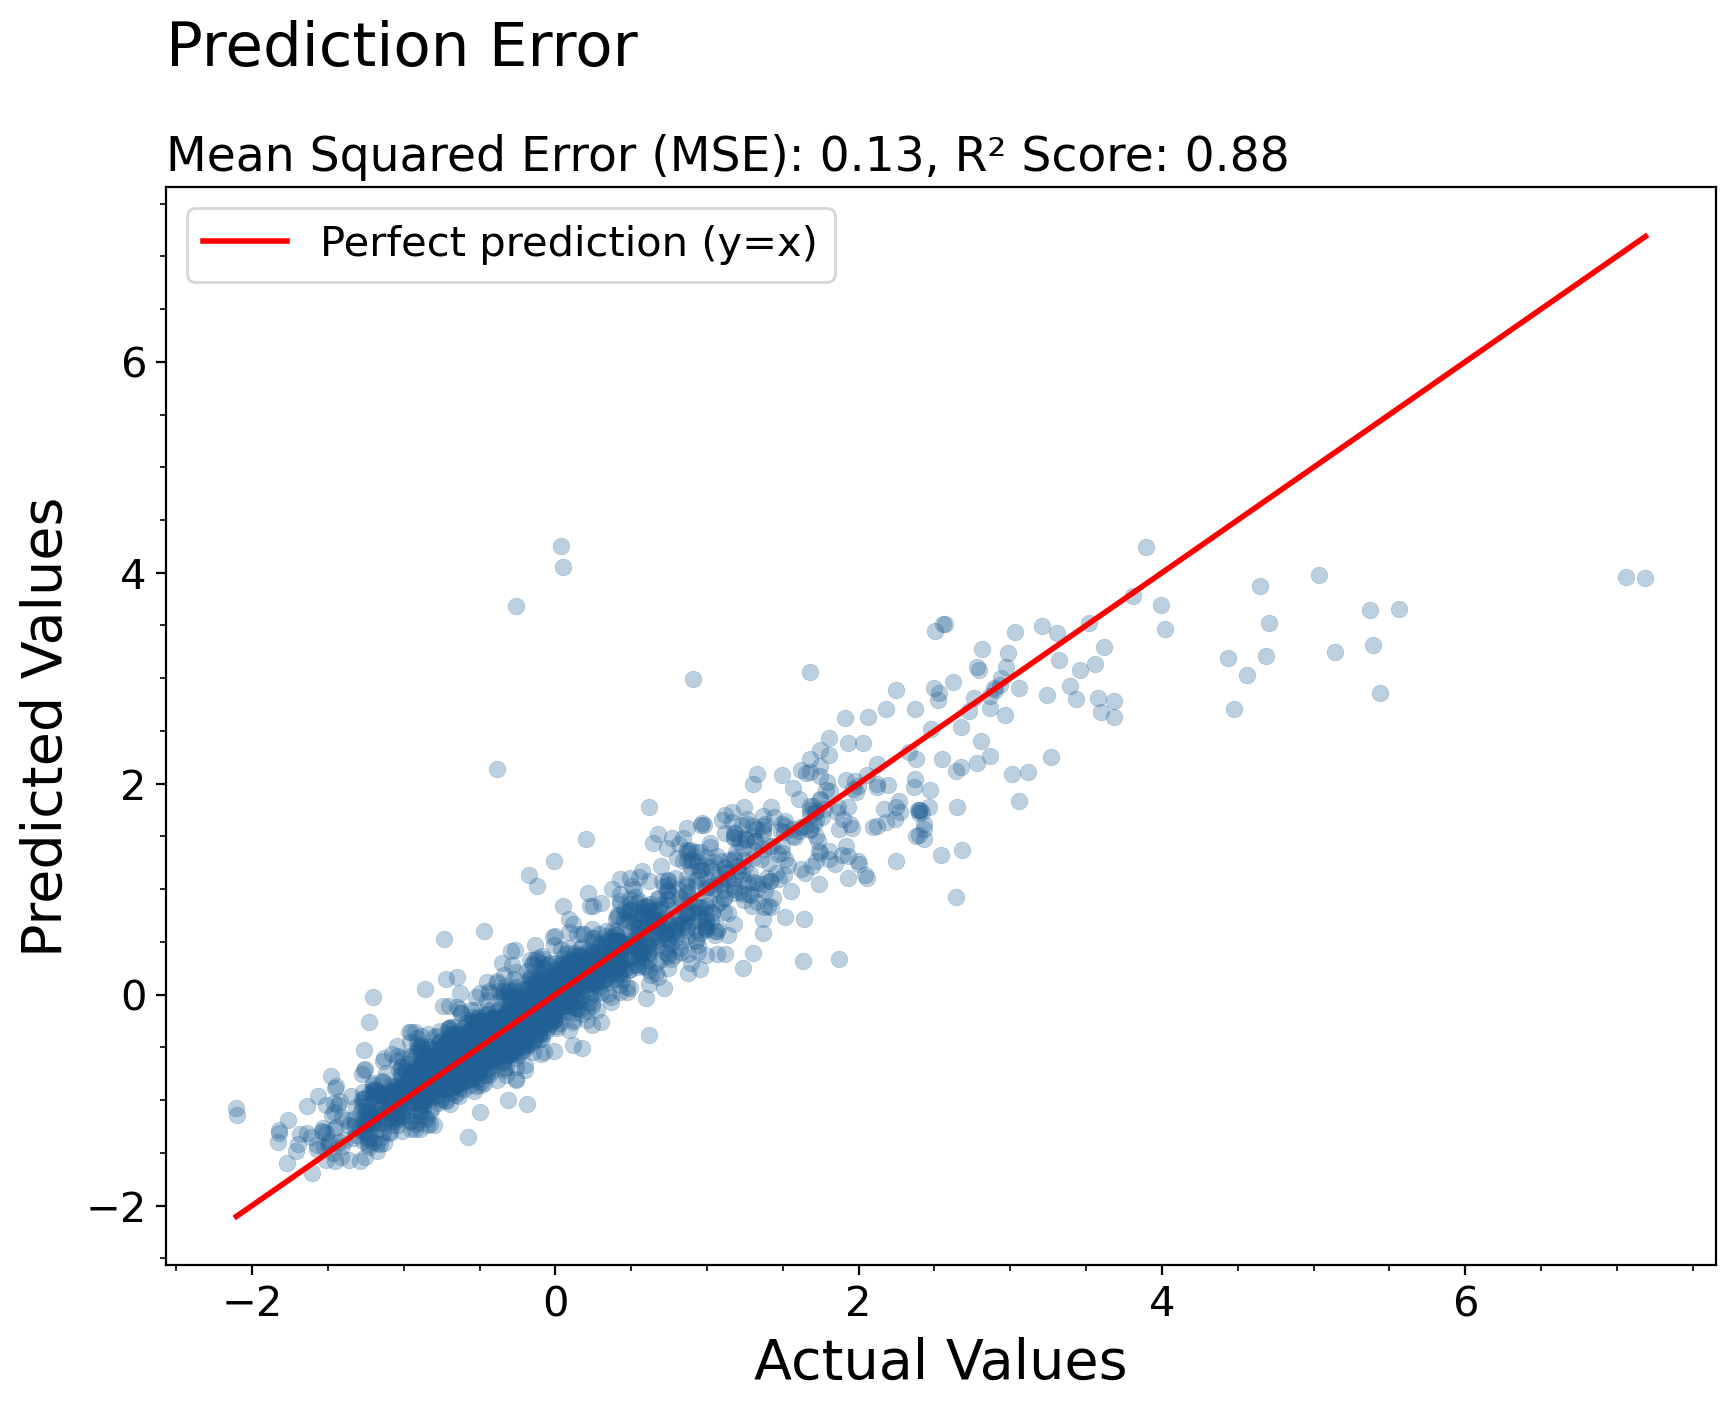

In [51]:
def PredictionErrorDisplay(y_true, y_pred):
    """Will Plot the residuals vs the predicted values. Aims to replicate the sklearn function with the same name
    (not available in current version).

    Args:
        y_true (list, array, pd.Series): List of true y values
        y_pred (list, array, pd.Series): List of y values predicted by the model
    """
    # Calculate Mean Squared Error and R² Score
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Create scatter plot of Actual vs Predicted
    fig, ax = plt.subplots(figsize=(10, 7), dpi=200)
    ax.scatter(y_true, y_pred, linewidths=0.2, alpha=0.3, color="#206095")

    # Add diagonal line (y=x) for perfect predictions
    ax.plot(
        [min(y_true), max(y_true)],
        [min(y_true), max(y_true)],
        color="red",
        linewidth=2,
        label="Perfect prediction (y=x)",
    )

    # Set titles and labels
    plt.suptitle(f"Prediction Error", ha="left", x=0.125, fontsize=22, y=1)
    ax.set_title(
        f"Mean Squared Error (MSE): {mse:.2f}, R² Score: {r2:.2f}",
        fontsize=17,
        ha="left",
        x=0,
    )
    ax.set_xlabel("Actual Values", fontsize=20)
    ax.set_ylabel("Predicted Values", fontsize=20)

    # Style ticks and grid
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.minorticks_on()

    # Add legend
    ax.legend(fontsize=15)

    plt.show()
    return None

PredictionErrorDisplay(y_full_test, preds)

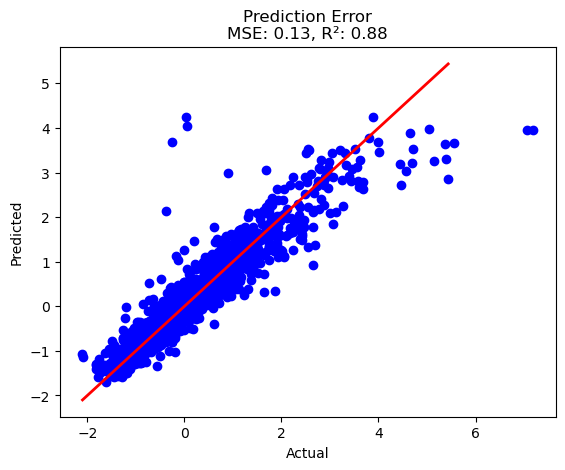

In [47]:



# Calculate Mean Squared Error and R² Score
mse = mean_squared_error(y_full_test, preds)
r2 = r2_score(y_full_test, preds)


# Plot the results
plt.scatter(y_full_test, preds, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Prediction Error\nMSE: {mse:.2f}, R²: {r2:.2f}')
plt.show()






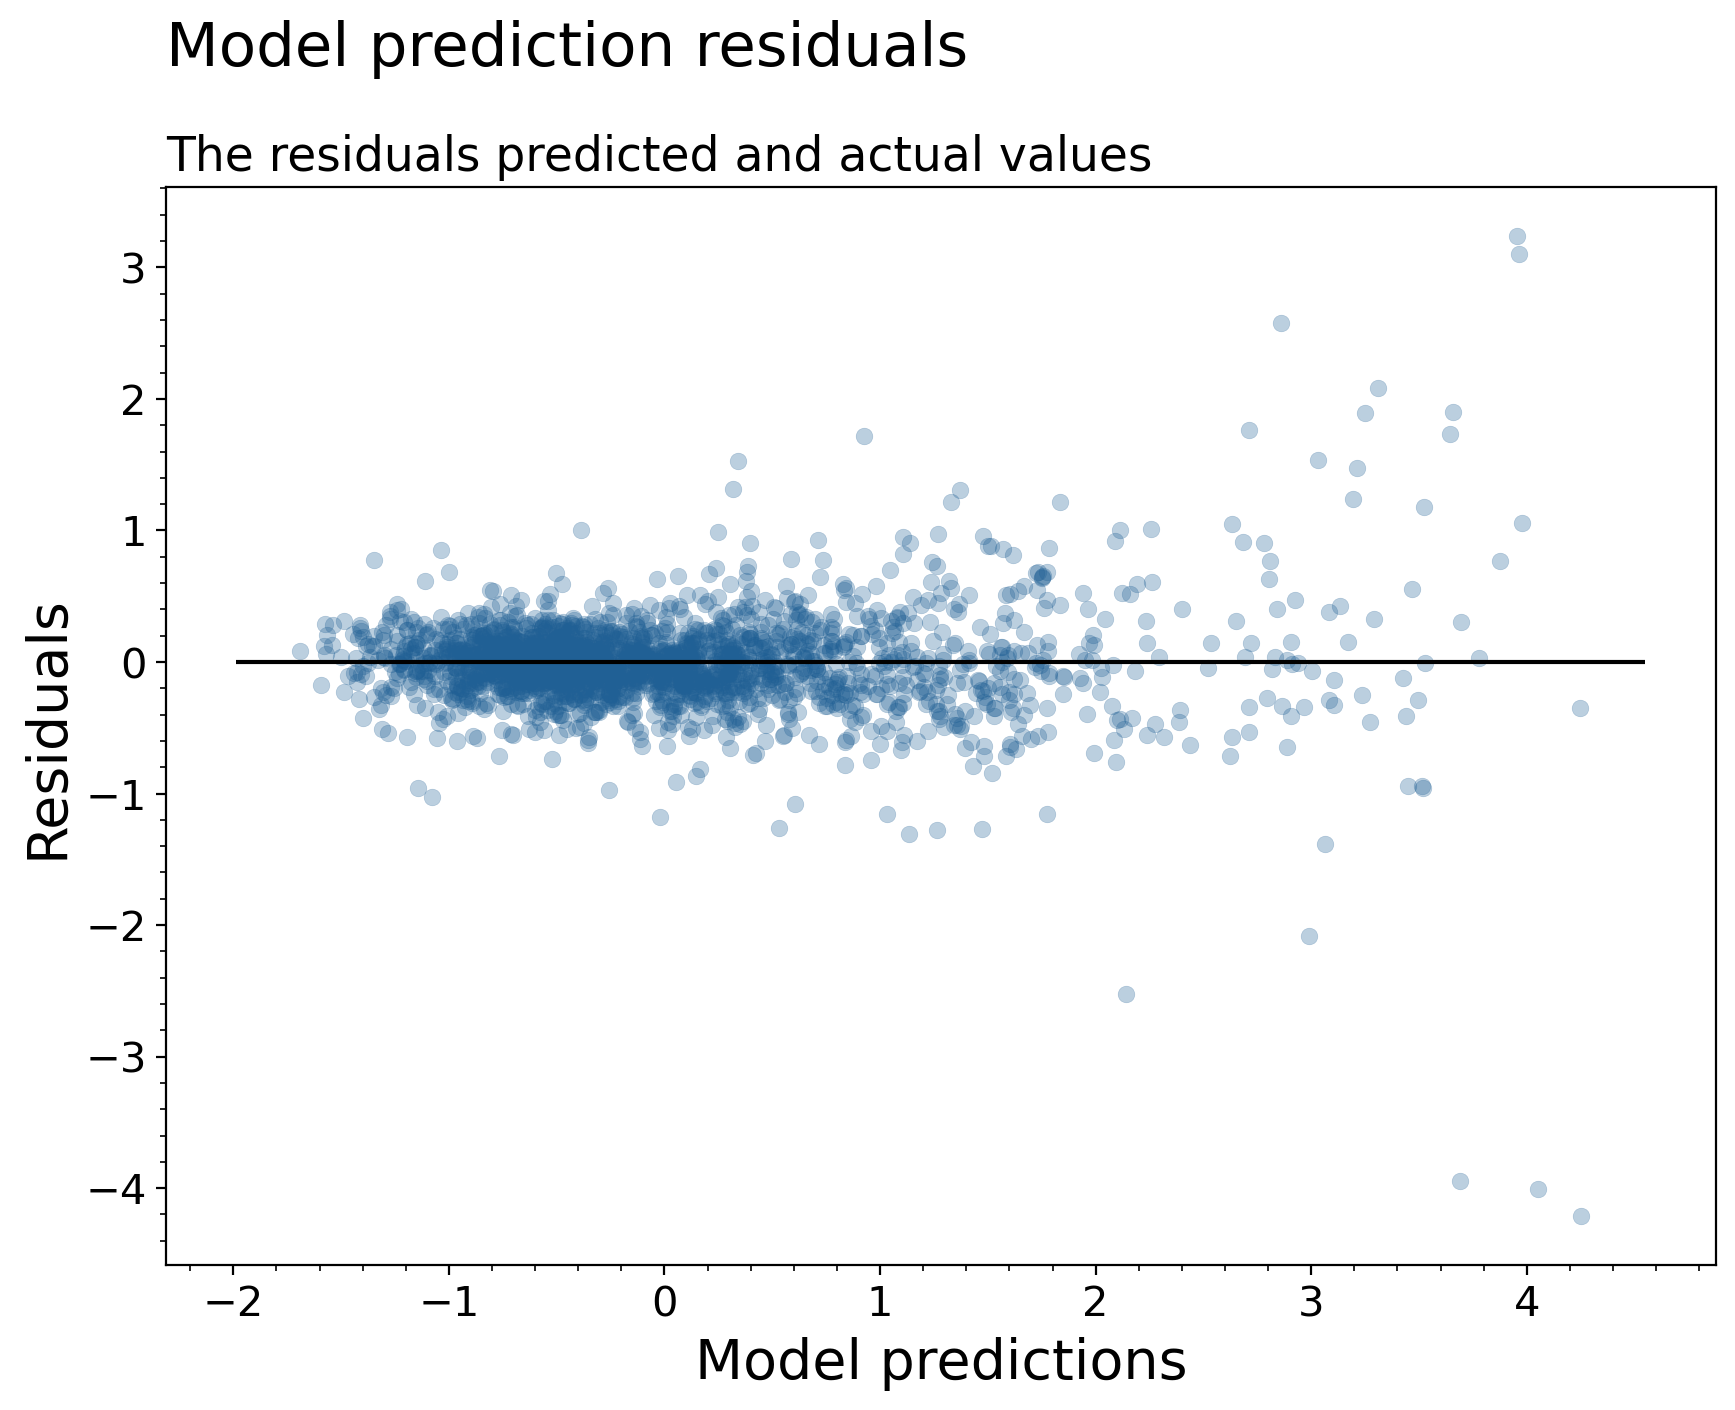

In [48]:
def PredictionErrorDisplay(y_true, y_pred):
    """Will Plot the Residuals vs the predicted values. Aims to replicate the sklearn function with the same name
    (not available in current version).

    Args:
        y_true (list, array, pd.Series): List of true y values
        y_pred (list, array, pd.Series): List of y values predicted by the model
    """
    # calculate residuals
    residuals = y_true - y_pred

    # plot residuals vs predicted values

    fig, ax = plt.subplots(figsize=(10, 7), dpi=200)
    ax.scatter(y_pred, residuals, linewidths=0.2, alpha=0.3, color="#206095")
    # zero line
    plt.suptitle(f"Model prediction residuals", ha="left", x=0.125, fontsize=22, y=1)
    ax.set_title(
        "The residuals predicted and actual values",
        fontsize=17,
        ha="left",
        x=0,
    )
    ax.set_xlabel(f"Model predictions", fontsize=20)
    ax.set_ylabel("Residuals", fontsize=20)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.minorticks_on()
    ax.hlines(
        y=0,
        xmin=ax.get_xlim()[0],
        xmax=ax.get_xlim()[1],
        linestyles="solid",
        color="k",
    )
    return None

PredictionErrorDisplay(y_full_test, preds)

In [36]:
accuracy = accuracy_score(y_full_test.astype(int), preds.astype(int))
print(accuracy)

0.8707337883959044


In [ ]:
X_val = pd.concat([X_val2, X_val3, X_val4])
y_val =  pd.concat([y_val2, y_val3, y_val4])['saleprice']

In [64]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)

# this sets a timer for how long we should run the optimisations
tic = time.time()
while time.time() - tic < 300:
    study.optimize(objective, n_trials=1)

[I 2025-01-09 11:03:06,551] A new study created in memory with name: no-name-4ac69fa7-20cf-40d1-a3a6-93edd5d655ae
[W 2025-01-09 11:03:06,564] Trial 0 failed with parameters: {'tree_method': 'hist', 'max_depth': 10, 'min_child_weight': 150, 'subsample': 0.24041677639819287, 'colsample_bynode': 0.2403950683025824, 'reg_lambda': 0.001800728515054226, 'learning_rate': 0.25998666758670563} because of the following error: KeyError('valid-rmse').
Traceback (most recent call last):
  File "C:\Users\ben\anaconda3\envs\ons_eval\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\ben\AppData\Local\Temp\ipykernel_11904\3714216175.py", line 18, in objective
    model = xgb.train(
            ^^^^^^^^^^
  File "C:\Users\ben\anaconda3\envs\ons_eval\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\ben\anaconda3\envs\ons_eval

KeyError: 'valid-rmse'

In [ ]:
xgb_train = xgb.DMatrix(X_train, y_train, enable_categorical=True)
xgb_test = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [ ]:
n=50
params = {
    'objective': 'reg:squarederror',
    'max_depth': 3,
    'learning_rate': 0.1,
}
 
model = xgb.train(params=params,dtrain=xgb_train,num_boost_round=n)

In [ ]:
preds = model.predict(xgb_test)
preds = preds.astype(int)
accuracy = accuracy_score(y_test.astype(int), preds.astype(int))
print('Accuracy of the model is:', accuracy*100)

In [ ]:
import yaml
from pathlib import Path
import time
import optuna